In [1]:
import MDAnalysis as mda 
import numpy as np
import pandas as pd
from MDAnalysis.analysis import distances
from MDAnalysis.analysis import contacts
import matplotlib.pyplot as plt

In [2]:
import analysis

In [3]:
def analyze_traj(xtc_file, folder, residue_id_sets):

    def add_residue_names_to_columns(columns, residue_ids, universe):
        protein_residues = universe.select_atoms("protein").residues
        new_columns = []

        for col in columns:
            if col.startswith("resid"):
                resid = int(col.split(" ")[1])
                if resid in residue_ids:
                    residue_name = protein_residues[resid - 1].resname
                    new_col = col.replace("resid", f"{residue_name} resid")
                else:
                    new_col = col
                new_columns.append(new_col)
            else:
                new_columns.append(col)

        return new_columns

    u = mda.Universe('../arfgap1/arfgap1.gro', xtc_file)
    TG = "(resname POPC DOPE SAPI) and (type C H)"
    TG2 = "(resname TRIO)"
    protein = u.select_atoms('protein')
    pl = u.select_atoms(TG)
    nl = u.select_atoms(TG2)

    output_prefix = f"{folder}/"

    for residue_set_idx, residue_ids in enumerate(residue_id_sets):
        analyzer = analysis.contact_analysis(u, residue_ids, pl, nl, radius=3.5)
        contacts_data = analyzer.analyze_contacts()

        columns = ['Frame']
        for resid in residue_ids:
            columns.append(f"resid {resid} PL acyl")
        for resid in residue_ids:
            columns.append(f"resid {resid} TG acyl")

        columns = add_residue_names_to_columns(columns, residue_ids, u)

        df = pd.DataFrame(np.array(contacts_data).T, columns=columns[1:])
        df['Frame'] = np.arange(len(df))
        df = df[columns]

        df.to_csv(output_prefix + f'../arfgap1/contacts_rep_set{residue_set_idx+1}.csv', index=False)
        rolling_mean = df.rolling(15).mean()
        rolling_mean.to_csv(output_prefix + f'../arfgap1/tot_ah_set{residue_set_idx+1}.csv', index=False)

        total_contacts = df[columns[1:]].sum(axis=1)
        total_contacts.to_csv(output_prefix + f'../arfgap1/combine_tot_set{residue_set_idx+1}.csv', index=False)


In [6]:
xtc_file = '../arfgap1/1.xtc'
output_folder = '../arfgap1'

residue_ids1 = list(range(1, 27))
# residue_ids2 = list(range(22, 40))
# residue_ids3 = list(range(41, 64))

# residue_id_sets = [residue_ids1, residue_ids2, residue_ids3]
residue_id_sets = [residue_ids1]

analyze_traj(xtc_file, output_folder, residue_id_sets)


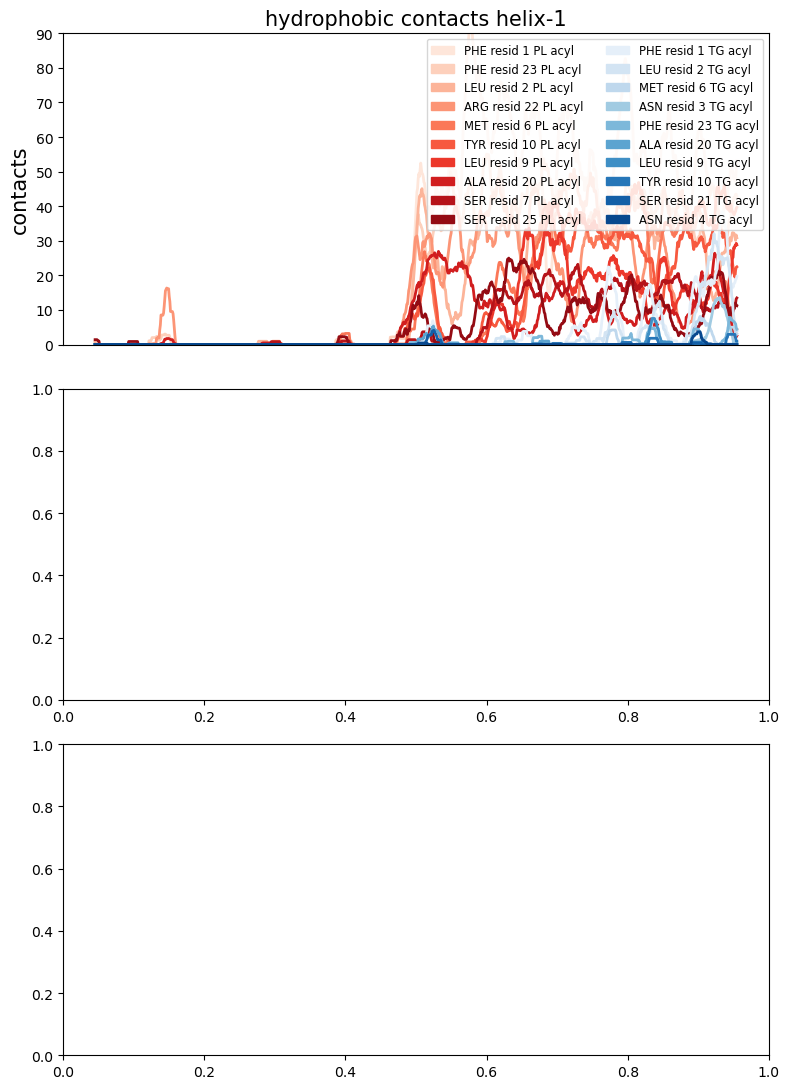

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns

def plot_data(folder_name, csv_files):
    fig, axs = plt.subplots(3, 1, figsize=(8, 11))
    axs = axs.ravel()
    red_colors = sns.color_palette("Reds", 10)
    blue_colors = sns.color_palette("Blues", 10)

    for i, csv_file in enumerate(csv_files):
        rol = pd.read_csv(f'{folder_name}/{csv_file}')
        
        # Select top 10 residues for PL acyl and TG acyl
        pl_acyl_columns = [col for col in rol.columns if 'PL acyl' in col]
        tg_acyl_columns = [col for col in rol.columns if 'TG acyl' in col]
        
        pl_acyl_top10 = rol[pl_acyl_columns].sum().nlargest(10).index
        tg_acyl_top10 = rol[tg_acyl_columns].sum().nlargest(10).index

        legend_elements = []
        
        for idx, col in enumerate(pl_acyl_top10):
            rol.plot(x='Frame', y=col, color=red_colors[idx], ax=axs[i], legend=None, linewidth=2)
            legend_elements.append(mpatches.Patch(color=red_colors[idx], label=f'{col}'))

        for idx, col in enumerate(tg_acyl_top10):
            rol.plot(x='Frame', y=col, color=blue_colors[idx], ax=axs[i], legend=None, linewidth=2)
            legend_elements.append(mpatches.Patch(color=blue_colors[idx], label=f'{col}'))

        axs[i].set_title(f'hydrophobic contacts helix-{i+1}',size=15)
        axs[i].set_ylim(0, 90)
        if i != 2:
            axs[i].set_xlabel("")
            axs[i].set_xticks([])
        else:
            axs[i].set_xlabel("time (ns)", size=15)
        axs[i].set_ylabel('contacts',size=15)
        
        # Add individual legend for each plot
        axs[i].legend(handles=legend_elements, loc='upper right', ncol=2, fontsize='small')

    plt.tight_layout()
    plt.savefig('../arfgap1/hydro_contacts.png', bbox_inches='tight', dpi=300)
    plt.show()

folder = '../arfgap1'
# csv_files = ['tot_ah_set1.csv', 'tot_ah_set2.csv', 'tot_ah_set3.csv']
csv_files = ['tot_ah_set1.csv']
plot_data(folder, csv_files)


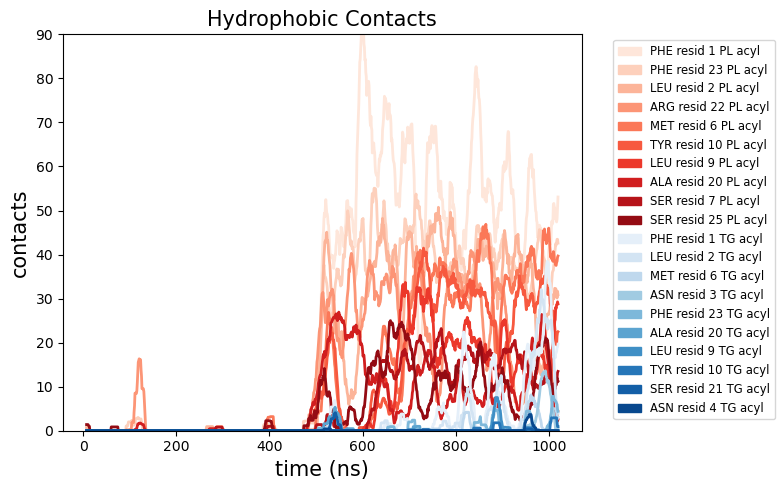

In [11]:
def plot_data(folder_name, csv_file):
    fig, ax = plt.subplots(figsize=(8, 5))
    red_colors = sns.color_palette("Reds", 10)
    blue_colors = sns.color_palette("Blues", 10)

    rol = pd.read_csv(f'{folder_name}/{csv_file}')
    
    # Select top 10 residues for PL acyl and TG acyl
    pl_acyl_columns = [col for col in rol.columns if 'PL acyl' in col]
    tg_acyl_columns = [col for col in rol.columns if 'TG acyl' in col]
    
    pl_acyl_top10 = rol[pl_acyl_columns].sum().nlargest(10).index
    tg_acyl_top10 = rol[tg_acyl_columns].sum().nlargest(10).index

    legend_elements = []
    
    for idx, col in enumerate(pl_acyl_top10):
        rol.plot(x='Frame', y=col, color=red_colors[idx], ax=ax, legend=None, linewidth=2)
        legend_elements.append(mpatches.Patch(color=red_colors[idx], label=f'{col}'))

    for idx, col in enumerate(tg_acyl_top10):
        rol.plot(x='Frame', y=col, color=blue_colors[idx], ax=ax, legend=None, linewidth=2)
        legend_elements.append(mpatches.Patch(color=blue_colors[idx], label=f'{col}'))

    ax.set_title(f'Hydrophobic Contacts', size=15)
    ax.set_ylim(0, 90)
    ax.set_xlabel("time (ns)", size=15)
    ax.set_ylabel('contacts', size=15)
    
    # Add individual legend for each plot
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small')

    plt.tight_layout()
    plt.savefig(f'{folder_name}/hydro_contacts.png', bbox_inches='tight', dpi=300)
    plt.show()

folder = '../arfgap1'
csv_file = 'tot_ah_set1.csv'
plot_data(folder, csv_file)


In [4]:
import mdtraj as md